### Customer segmentation 

In [2]:
# Data manipulation 
import pandas as pd
# Linear algebra
import numpy as np
# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
# Date and Time
import datetime, nltk, warnings
# Imporiting
import itertools
from pathlib import Path
# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
# Visualization
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, HTML
# Further needs
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [3]:
# Load data set 
folder = "C:/Users/kurtk/OneDrive/Documents/Python projects/Customer segmentation" 
file = "/data.csv"
df = folder + file

df = pd.read_csv(df,encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})



In [4]:
# Check the shape of the data
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (541909, 8)


In [5]:
# show information on column types and number of null values in each column
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

tab_info = pd.concat([tab_info, pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info= pd.concat([tab_info, pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'})])

tab_info.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,object,float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


Based off of the above we need to change the data type of Invoice date 

In [6]:
# Convert Invoice Data to date time object
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### View the data set 

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Based on the above description of the data in the info table it is apparent that 25% of the Customer ID column is filled with Null values, if there is no unique identifier for the customer then we cannot segment the clients based off of this. Thus, we will drop them from the analysis in this instance. 

In [8]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df.shape)

# Re-show the info table
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

tab_info = pd.concat([tab_info, pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info= pd.concat([tab_info, pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'})])

tab_info.head()

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we check for any repeated entries in the data set and remove these.

In [9]:
# Check for duplicates
print('Duplicate entries: {}'.format(df.duplicated().sum()))
# Drop duplicated entries
df.drop_duplicates(inplace = True)

Duplicate entries: 5225


In [10]:
# Check the final sahpe of the data set 
df.shape

(401604, 8)

Now it is clear that there are no missing values from data set. Hence, we can begin to perform our analysis. 

#### A detailed description of each of the features present in the data set

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it    indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.
    

#### Countries

Number of countires present in the dataframe 

In [11]:
# Subset the data by " CustomerID... "
subset = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
subset = subset.reset_index(drop = False)

# Count number of countries
countries = subset['Country'].value_counts()

print('Number of countries present in the data: {}'.format(len(countries)))

Number of countries present in the data: 37


Lets plot a map of the countries and base the colour on the frequency of orders from that country

In [12]:
# Create the plot
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

Based off the map, it is to tell that the majority of orders are coming from the UK

#### Consumers and products

In [13]:
# Creating a smaller df to show consumer and product info
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])


,products,transactions,customers
quantity,3684,22190,4372


In [14]:
# Checking the number of products purcahsed per a transaction 
subset = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = subset.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


#### Cancellling of order made 

In [15]:
# Create a new column in the subset 'nb_products_per_basket'
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

# Show the number of cancelations 
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


Lets order the df by Customer ID 

In [16]:
display(df.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


Based on what we can see above there are duplicate entries creatred for cancellations, these are denoted with the "C" in Invoice number as stated above in the description of features. We need to check that this is in fact that the system that is used to denote cancellations, in order to do so we need to locate each order the has a corresponding "negation" or "negative" order qunatity 

In [17]:
df_check = df[df['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' The existance of dsicounts disapproves our intial assumptions')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> The existance of dsicounts disapproves our intial assumptions


In [18]:
df_check = df[(df['Quantity'] < 0) & (df['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+'Our intial assumptions is not true as not every instance of negative qunatity corresponds to a postive one')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
--------------->Our intial assumptions is not true as not every instance of negative qunatity corresponds to a postive one


I nthe followoing we will create a feature that indicates whether or not there has been a cancellation on an order and the quantity assocaiated with that cancellation. 

Further, we will check for any doubtfull enterires or enteries that should be removed based on no existing counter part in the data set. 

- These list are named:
    - entry_to_remove
    - doubtfull_entry

In [19]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)  
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break  

Lets view the lists:

In [20]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


Now we will remove these enteries from the data set

Further, we will check to  see 

In [22]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

# check the number of entries that correspond to cancellations and that have not been deleted with the previous filter
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))

remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [23]:
df_cleaned[(df_cleaned['CustomerID'] == 15358) & (df_cleaned['StockCode'] == '84535B')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


These enteries no longer exist in the cleaned df

#### Stock codes

We want to check for unique instances in the stock code, eg 'D' is discount. 

In [24]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

These itemes refer to the following:

- POST:            -> POSTAGE                       
- D:               -> Discount                      
- C2:              -> CARRIAGE                      
- M:               -> Manual                        
- BANK CHARGES:    -> Bank Charges                  
- PADS:            -> PADS TO MATCH ALL CUSHIONS    
- DOT:             -> DOTCOM POSTAGE 



#### Basket price  

In [25]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


In [26]:
# Sum Bought / used & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
     # Select the significant enterires
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


#### Visualizing the size of baskets 

[1142, 1063, 4001, 8084, 2830, 1157, 108]
[1142, 1063, 4001, 8084, 2830, 1157, 108]


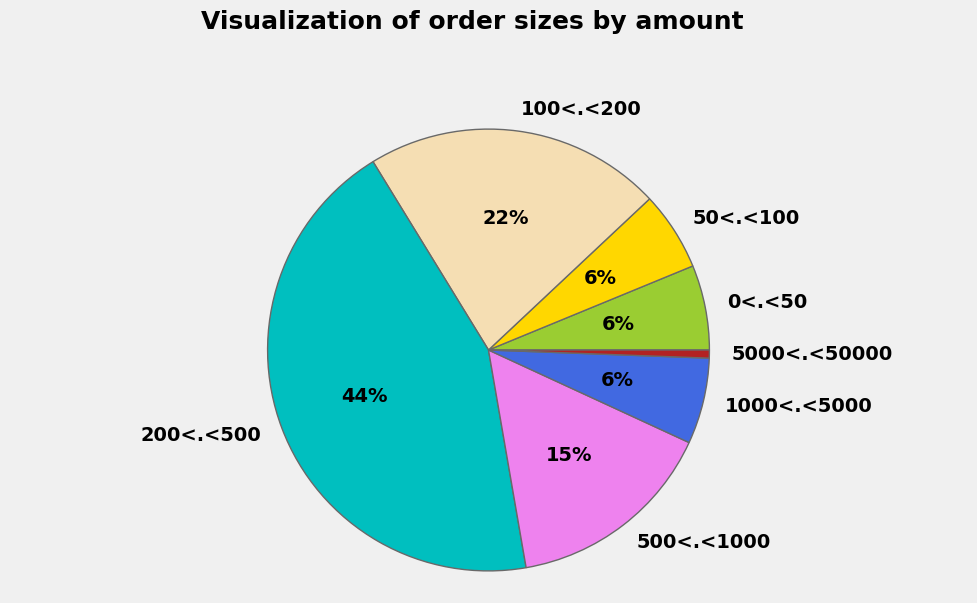

In [37]:
#basket_price DataFrame
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

# Loop through price ranges
for i, price in enumerate(price_range):
    if i == 0: 
        continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Check the count_price list
print(count_price)

# Number of purchases by amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i, s in enumerate(price_range) if i != 0]
sizes  = count_price

# Check sizes before plotting
print(sizes)

# Avoiding empty slices by checking if any size is above a threshold
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]

# Create pie chart
ax.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct=lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')

# Add title
f.text(0.5, 1.01, "Visualization of order sizes by amount", ha='center', fontsize=18)

# Show the plot only once
plt.show() 

#### Insight on product categories

Using the content of the description category to group the products into different categories

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

- Extract the names (proper, common) appearing in the products description
- For each name, I extract the root of the word and aggregate the set of names associated with this particular root
- Counts the number of times each root appears in the dataframe
- When several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

In [53]:
# Importy as is needed for function 
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\kurtk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [55]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

Step one of this analysis is to retrive the list of products

In [56]:
df_produits = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})

Once we have this list we will use it to analyse the description of the different products on offer

In [57]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1483


In [59]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Mostly commonly used key words

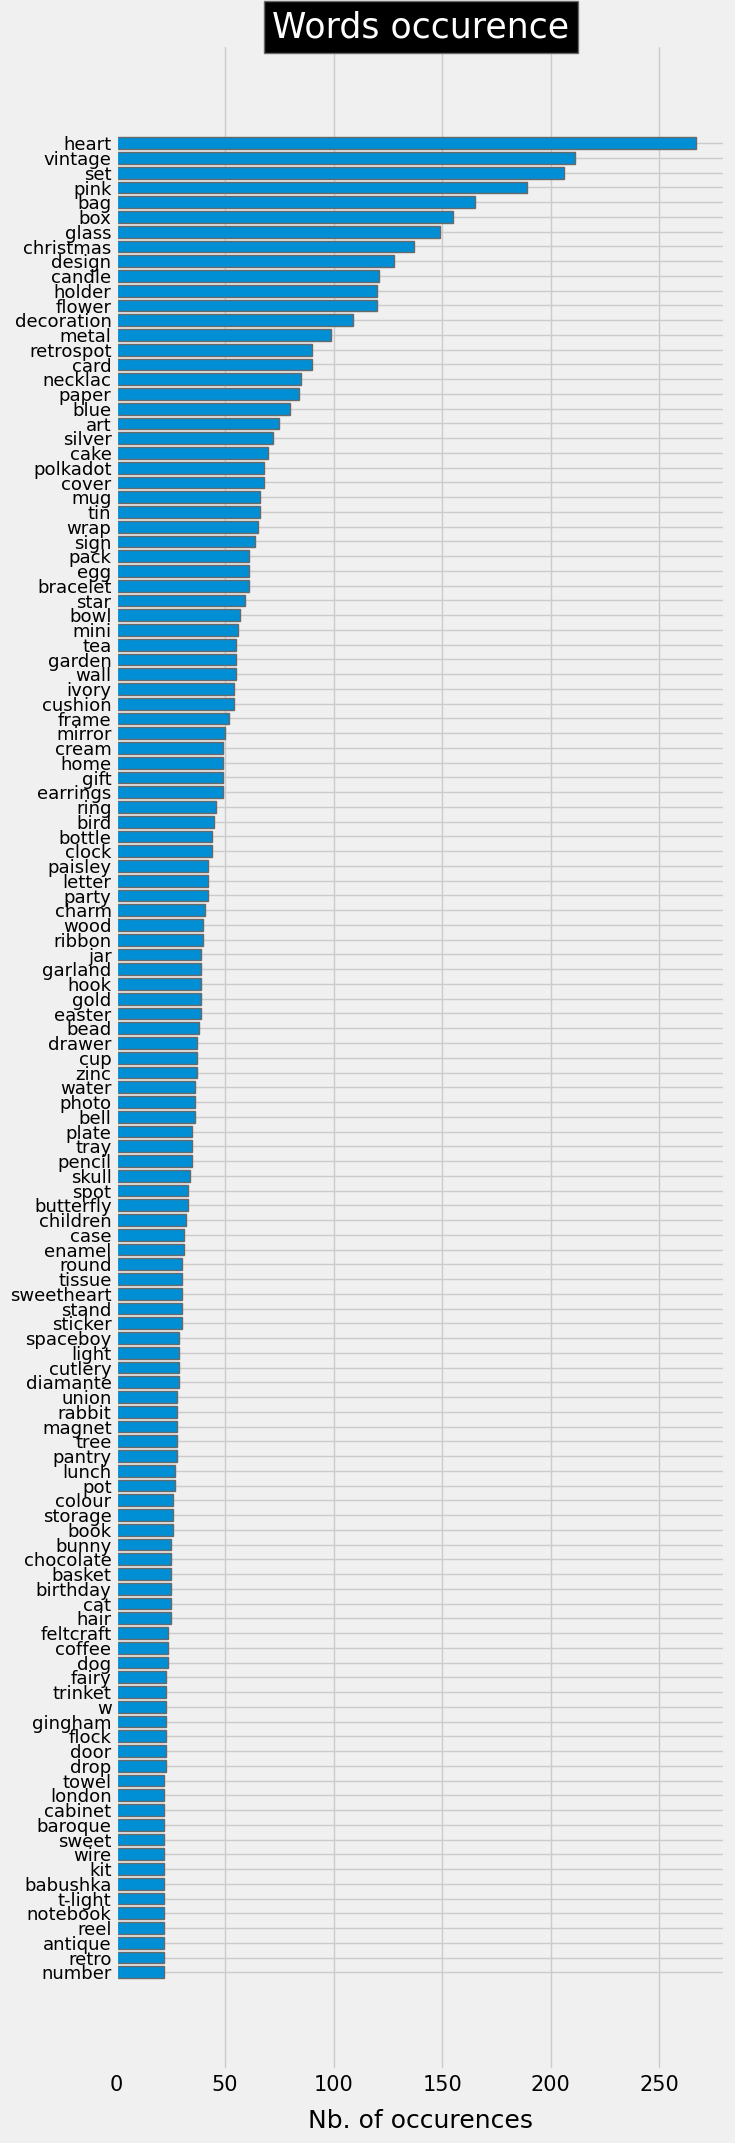

In [60]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

Defining product categories

In [62]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Words saved:', len(list_products))

Words saved: 193


We define a matrix to discover word and product associations

In [66]:
list_products_1 = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_products_1))

The matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, we have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, we add 6 extra columns to this matrix, where we indicate the price range of the products:

In [67]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

 In order to asign the appropriate ranges, we check the number of products in the different groups:

In [69]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


####  Creating clusters of products

In [72]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14708700459493795
For n_clusters = 6 The average silhouette_score is : 0.14509988406712557
For n_clusters = 7 The average silhouette_score is : 0.14225706979096936
For n_clusters = 8 The average silhouette_score is : 0.15342109568144105
For n_clusters = 9 The average silhouette_score is : 0.1336948441240667


The scores obtained above can be considered equivalent since, depending on the run, scores of  0.1 ± 0.05
will be obtained for all clusters with n_clusters >3 (we obtain slightly lower scores for the first cluster). On the other hand, we have found that beyond 5 clusters, some clusters contained very few elements. We therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, we iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [74]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14740815062347604


 Characterizing the content of clusters

In [76]:
pd.Series(clusters).value_counts()

0    1009
3     964
1     673
2     626
4     606
Name: count, dtype: int64

Checking the number of elements in every class

In [78]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
   
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

In [79]:
pd.Series(clusters).value_counts()

0    1009
3     964
1     673
2     626
4     606
Name: count, dtype: int64

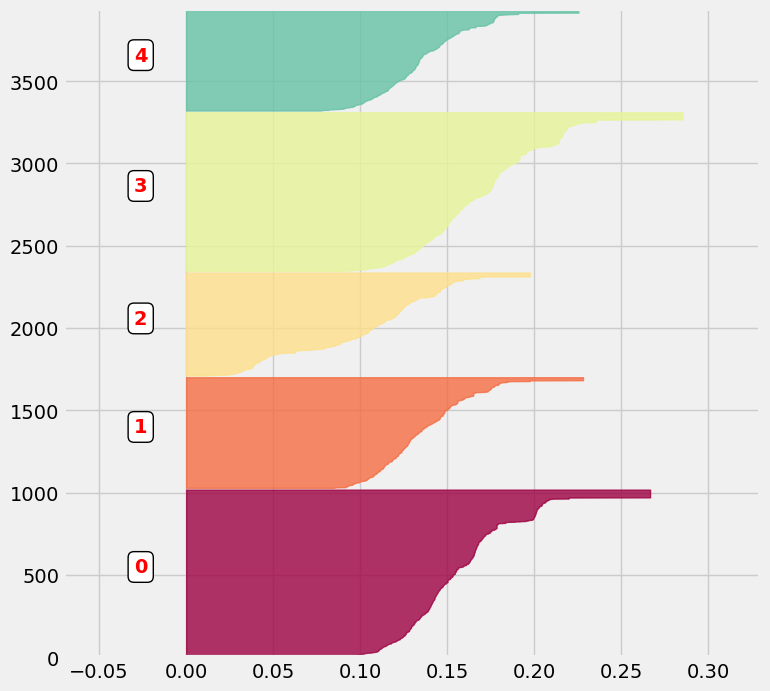

In [82]:
# Define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
# Create the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

plt.show()

In [84]:
lists = pd.DataFrame(liste_produits)
lists_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = lists.loc[clusters == i]
    for word in lists_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

Output the word clouds

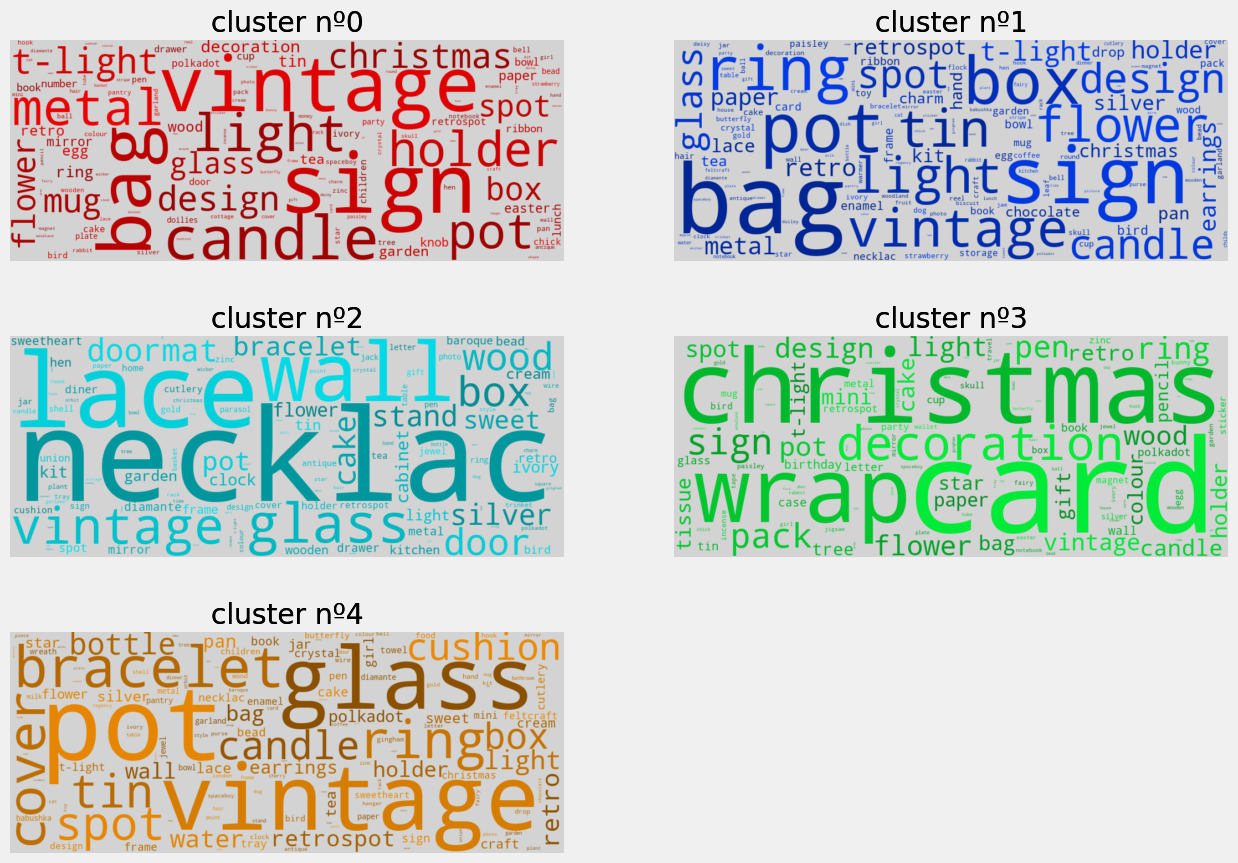

In [86]:

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
   
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)     

plt.show()

From the plot, we can see one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card etc). Another cluster contains luxury items and jewelry (keywords: necklace, bracelet, lace, silver etc). It can be observed the each of the clusters contain many words and this it is difficult to differentiate one from another.

#### Principle comoponnet analysis

In [88]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

Check the amount of variance explained by each component:

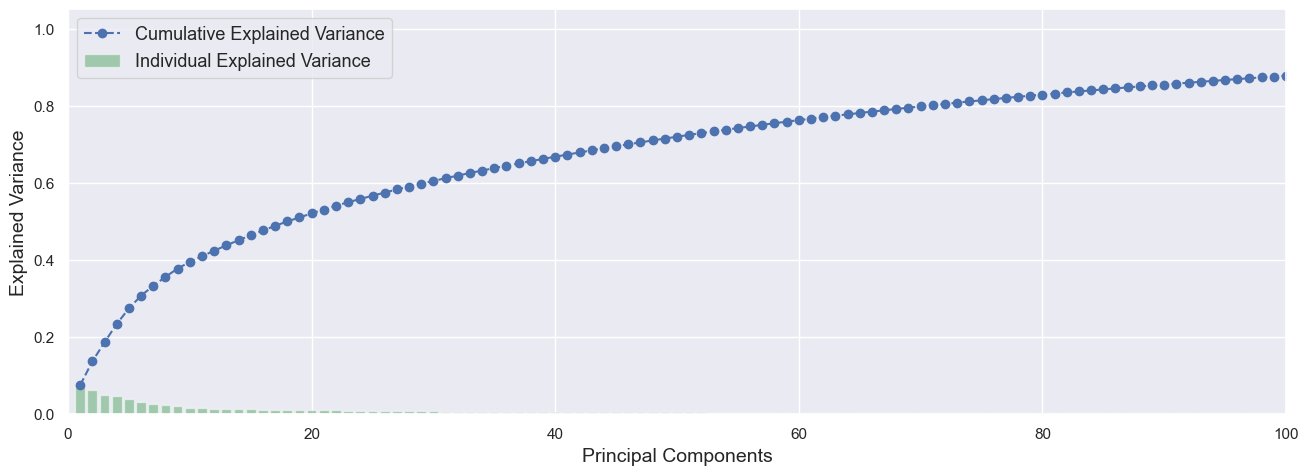

In [93]:
plt.close('all')  # Clears previous figures

fig, ax = plt.subplots(figsize=(14, 5))  # Creates a single figure

sns.set(font_scale=1)

# Line plot for cumulative explained variance
plt.plot(range(1, matrix.shape[1] + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')

# Bar plot for individual explained variance
plt.bar(range(1, matrix.shape[1] + 1), 
        pca.explained_variance_ratio_, 
        alpha=0.5, color='g', label='Individual Explained Variance')

plt.xlim(0, 100)

plt.ylabel('Explained Variance', fontsize=14)
plt.xlabel('Principal Components', fontsize=14)
plt.legend(loc='upper left', fontsize=13)

plt.show()

The number of components required to explain the data is extremely important. We would need more than 100 components to explain 90% of the variance of the data. In practice, we decide to keep only a limited number of components since this decomposition is only performed to visualize the data.

In [94]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

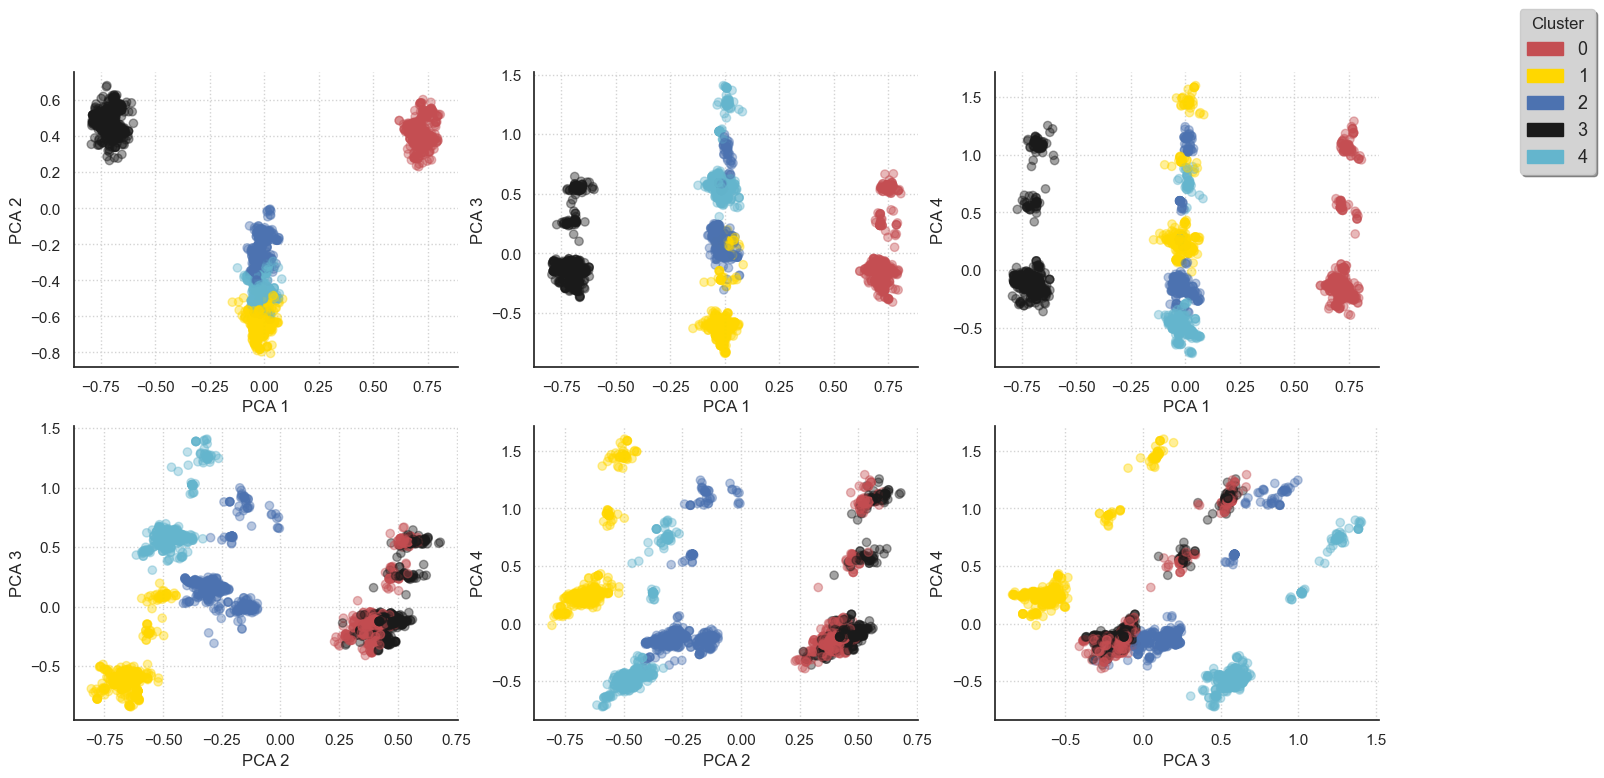

In [95]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        

# Set the legend
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

### Customer categories 

In [99]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

Grouping by products

In [100]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.0,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.0,0.0,20.34


The information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. Therefore we can create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products

In [105]:
# Aggregate purchases and orders at the Customer & Invoice level
basket_price = df_cleaned.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price.rename(columns={'TotalPrice': 'Basket Price'}, inplace=True)

# Calculate category-wise percentage price of the order
for i in range(5):
    col_name = f'categ_{i}'
    temp = df_cleaned.groupby(['CustomerID', 'InvoiceNo'], as_index=False)[col_name].sum()
    basket_price = basket_price.merge(temp, on=['CustomerID', 'InvoiceNo'], how='left')

# Convert InvoiceDate to numeric and compute the average date per order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].view('int64')  # Avoids deprecated `.astype('int64')`
invoice_dates = df_cleaned.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

# Merge computed InvoiceDate back and convert to datetime
basket_price = basket_price.merge(invoice_dates, on=['CustomerID', 'InvoiceNo'], how='left')
basket_price['InvoiceDate'] = pd.to_datetime(basket_price['InvoiceDate_int'])
basket_price.drop(columns=['InvoiceDate_int'], inplace=True)

# Keep only significant orders (where Basket Price > 0)
basket_price = basket_price[basket_price['Basket Price'] > 0]

# Display first 5 entries sorted by CustomerID
basket_price.sort_values('CustomerID').head(5)

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,187.2,83.40,124.44,23.40,293.35,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,130.5,53.10,38.25,84.34,169.20,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,330.9,71.10,38.25,81.00,115.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,74.4,78.06,19.90,41.40,168.76,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,109.7,119.70,136.05,61.30,158.16,2011-08-02 08:48:00.000000000


#### Seperation over time


The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, we split the data set by retaining the first 10 months to develop the model and the following two months to test it

In [106]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [110]:
basket_price.dtypes

CustomerID              object
InvoiceNo               object
Basket Price           float64
categ_0                float64
categ_1                float64
categ_2                float64
categ_3                float64
categ_4                float64
InvoiceDate     datetime64[ns]
dtype: object

In [111]:
# Define the cutoff date
cutoff_date = pd.Timestamp("2011-10-01")

# Split data into training and test sets
train_set = basket_price[basket_price['InvoiceDate'] < cutoff_date]
test_set  = basket_price[basket_price['InvoiceDate'] >= cutoff_date]

# Make a copy of the training set (optional, only if modifications are needed)
basket_price = train_set.copy()

#### Consumer Order Combinations


In a second step, we group together the different entries that correspond to the same user. Thus determining the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [113]:
# Number of visits and basket amount statistics per user
transactions_per_user = basket_price.groupby('CustomerID')['Basket Price'].agg(
    count='count', min='min', max='max', mean='mean', sum='sum'
).reset_index()

# Calculate category-wise percentage contributions
for i in range(5):
    col_name = f'categ_{i}'
    category_sum = basket_price.groupby('CustomerID')[col_name].sum().reset_index()
    category_sum[col_name] = (category_sum[col_name] / transactions_per_user['sum']) * 100
    transactions_per_user = transactions_per_user.merge(category_sum, on='CustomerID', how='left')

# Display the first 5 rows sorted by CustomerID
transactions_per_user.sort_values('CustomerID').head(5)

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,14.524555,12.787815,10.442659,32.408290
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,20.030714,38.016069,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,27.900718,11.961722,11.692584,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,3.370331,67.534402,0.491808,15.711338
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,19.887640,67.078652,0.000000,0.000000


Finally we define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [115]:
# Get the last available invoice date
last_date = basket_price['InvoiceDate'].max()

# Calculate first and last purchase dates per customer
purchase_dates = basket_price.groupby('CustomerID')['InvoiceDate'].agg(
    FirstPurchase='min', LastPurchase='max'
).reset_index()

# Calculate days since first and last purchase
purchase_dates['DaysSinceFirstPurchase'] = (last_date - purchase_dates['FirstPurchase']).dt.days
purchase_dates['DaysSinceLastPurchase'] = (last_date - purchase_dates['LastPurchase']).dt.days

# Merge with transactions_per_user
transactions_per_user = transactions_per_user.merge(purchase_dates, on='CustomerID', how='left')

# Display first 5 rows
transactions_per_user.head(5)

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,FirstPurchase,LastPurchase,DaysSinceFirstPurchase,DaysSinceLastPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,14.524555,12.787815,10.442659,32.408290,2010-12-07 14:57:00.000000000,2011-08-02 08:48:00,297,59
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,20.030714,38.016069,0.000000,2010-12-16 19:09:00.000000000,2011-09-25 13:13:00,287,5
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,27.900718,11.961722,11.692584,0.000000,2011-02-02 16:01:00.000000000,2011-02-02 16:01:00,239,239
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,3.370331,67.534402,0.491808,15.711338,2011-02-16 12:32:59.999999744,2011-09-28 14:58:00,226,2
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,19.887640,67.078652,0.000000,0.000000,2011-05-19 17:47:00.000000000,2011-05-19 17:47:00,133,133


A customer category of particular interest is that of customers whom only purchase once. One of the objectives may be, for example, to target these customers in order to retain this group. In part, we find that this type of customer represents 1/3 of the customers listed, a siginificant group to target with a potential ad campaign.

In [117]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("nb. of clients with unique purchase orders: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. of clients with unique purchase orders: 1445/3608  (40.05%)


#### Creation of customers categories

##### Data encoding

The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. We use this information to characterize the different types of customers and only keep a subset of variables.


In [120]:
# Define the list of columns to select
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']

# Select customers' data based on defined columns
selected_customers = transactions_per_user[list_cols].copy()  # Only make a copy if you need to modify it

# Convert the DataFrame to a NumPy array (using .to_numpy() instead of .as_matrix())
matrix = selected_customers.to_numpy()

The different variables selected have a different ranges of variation and before continuing the analysis, we need to create a matrix where the data can be  standardized

In [122]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  25.22916919
  21.19884856  23.21847344  13.98907929  16.37327913]


Now we create clusters of customers. Before creating these clusters, it is interesting to define a base of smaller dimensions allowing to describe the scaled_matrix. In this case, we will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. we therefore perform PCA.

In [124]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

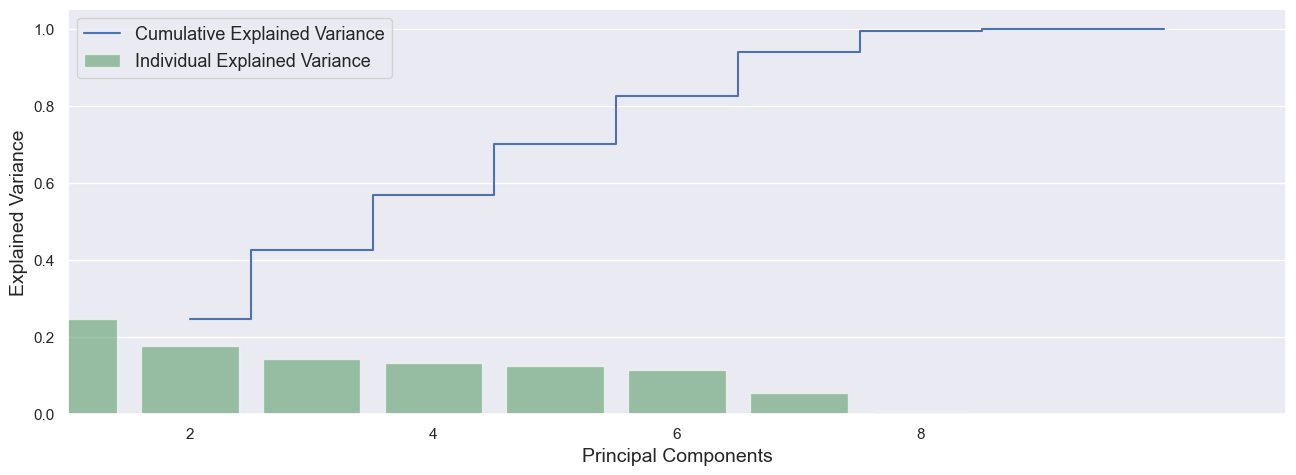

In [127]:
plt.close('all')  # Clears previous figures

# Set figure and axis
fig, ax = plt.subplots(figsize=(14, 5))

# Set font scale for seaborn
sns.set(font_scale=1)

# Plot cumulative explained variance
ax.step(range(1, matrix.shape[1] + 1), 
        pca.explained_variance_ratio_.cumsum(), 
        where='mid', 
        label='Cumulative Explained Variance', color='b')

# Plot individual explained variance as a bar plot
sns.barplot(x=np.arange(1, matrix.shape[1] + 1), 
            y=pca.explained_variance_ratio_, 
            alpha=0.6, 
            color='g', 
            label='Individual Explained Variance', ax=ax)

# Set x-axis limit
plt.xlim(0, 10)

# Improve x-axis labels: show every other label
ax.set_xticklabels([str(i) if i % 2 == 0 else '' for i in range(1, matrix.shape[1] + 1)])

# Set axis labels and title
plt.ylabel('Explained Variance', fontsize=14)
plt.xlabel('Principal Components', fontsize=14)

# Set legend position
plt.legend(loc='best', fontsize=13)

# Show the plot
plt.show()

We can now define clusters of clients from the standardized matrix that we defined earlier and using the k-means algorithm fromscikit-learn. We choose the number of clusters based on the silhouette score, the best score is obtained with 11 cluster.

In [129]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.217


A look at the number of customers in each cluster

In [141]:
# Count the number of clients in each cluster and create a DataFrame
cluster_counts = pd.Series(clusters_clients).value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Number of clients']

# Display the result (no need for transpose)
cluster_counts.sort_values(by = 'Number of clients', ascending = False)

,Cluster,Number of clients
0,2,1438
1,10,505
2,5,455
3,9,294
4,0,289
5,4,230
6,1,189
7,3,177
8,6,12
9,7,11


Show results via the PCA

In [134]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

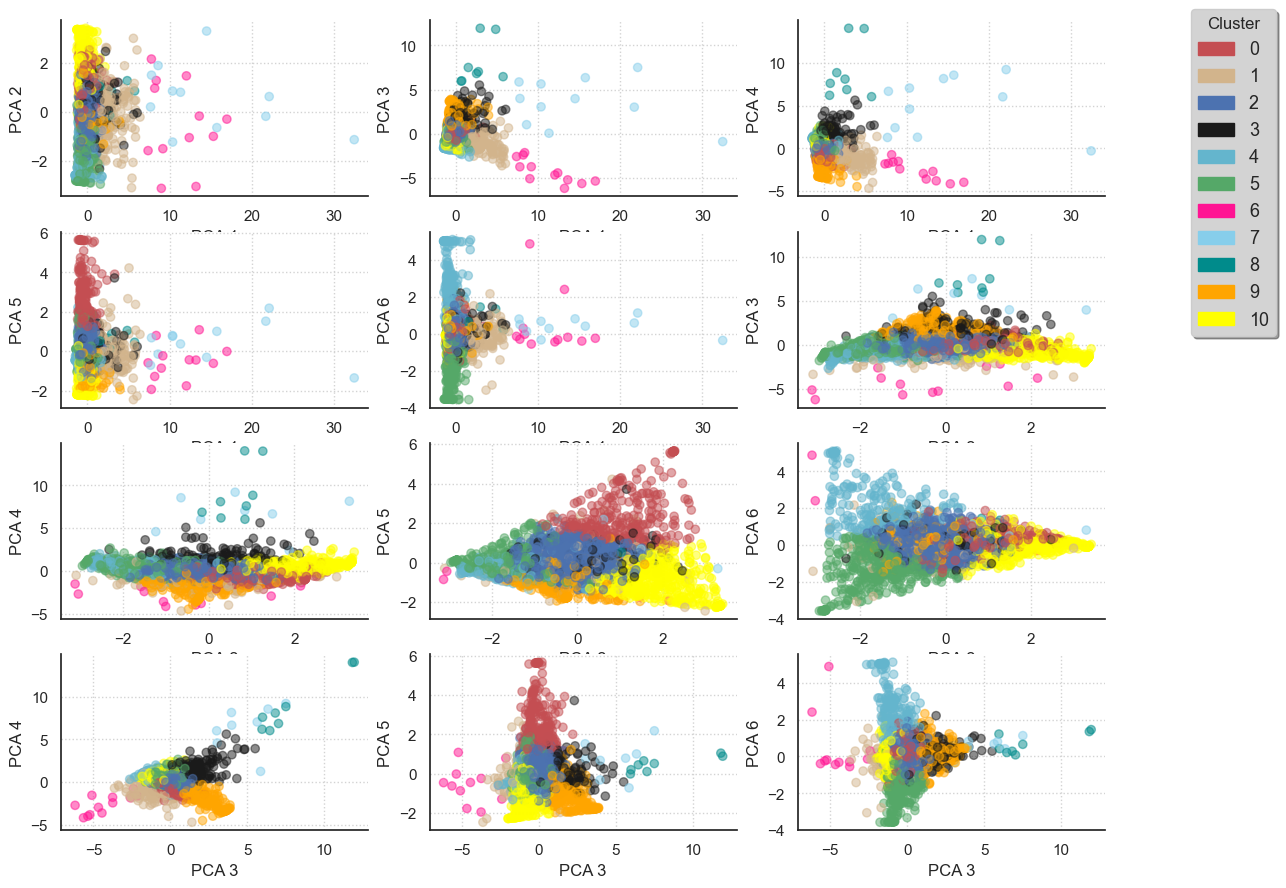

In [138]:
plt.close('all') # Clear previous figures

# Set the Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

# Define color map for clusters
LABEL_COLOR_MAP = {
    0: 'r', 1: 'tan', 2: 'b', 3: 'k', 4: 'c', 5: 'g', 6: 'deeppink', 7: 'skyblue', 
    8: 'darkcyan', 9: 'orange', 10: 'yellow', 11: 'tomato', 12: 'seagreen'
}

# Assign colors to labels
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

# Create a figure for plotting
fig = plt.figure(figsize=(12, 10))

# Initialize increment
increment = 0

# Create subplots for each pair of PCA components
for ix in range(6):
    for iy in range(ix + 1, 6):
        increment += 1
        ax = fig.add_subplot(4, 3, increment)

        # Scatter plot with color based on cluster labels
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.5)

        # Label the axes
        ax.set_xlabel(f'PCA {ix + 1}', fontsize=12)
        ax.set_ylabel(f'PCA {iy + 1}', fontsize=12)

        # Customize grid and remove top/right spines
        ax.grid(True, linestyle=':', color='lightgray')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Stop if all subplots are created
        if increment == 12:
            break
    if increment == 12:
        break

# Create the legend using patches for each cluster
comp_handler = [mpatches.Patch(color=LABEL_COLOR_MAP[i], label=str(i)) for i in range(n_clusters)]

# Display the legend
plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), title='Cluster', 
           facecolor='lightgrey', shadow=True, frameon=True, framealpha=1, 
           fontsize=13, bbox_transform=plt.gcf().transFigure)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

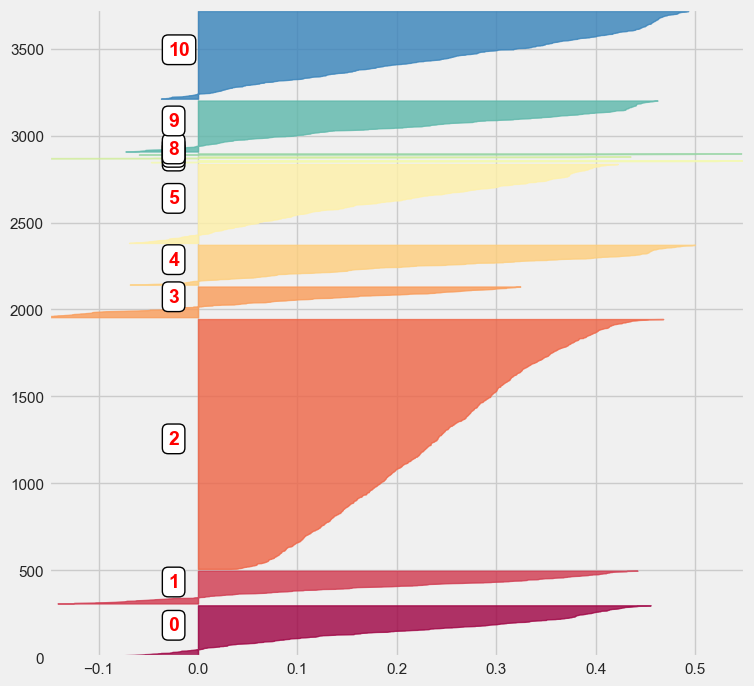

In [139]:
# Calculate silhouette scores for each sample
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# Define the range for plotting (you can adjust the range if necessary)
silhouette_range = [-0.15, 0.55]

# Generate the silhouette plot
graph_component_silhouette(n_clusters, silhouette_range, len(scaled_matrix), sample_silhouette_values, clusters_clients)

# Display the plot
plt.show()

#### Customers morphotype

At this stage, we have verified that the different clusters are indeed disjoint. It remains to understand the habits of the customers in each cluster. To do so, we start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [143]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [147]:
# Initialize an empty list to collect cluster stats
cluster_stats = []

# Loop through each cluster and calculate the mean and size
for i in range(n_clusters):
    # Calculate mean values for the selected customers in each cluster
    cluster_data = selected_customers[selected_customers['cluster'] == i].mean()
    
    # Add cluster index and size information
    cluster_data['cluster'] = i
    cluster_data['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    
    # Append to the list
    cluster_stats.append(cluster_data)

# Convert the list of stats into a DataFrame
merged_df = pd.DataFrame(cluster_stats)

# Drop 'CustomerID' column (if exists)
merged_df.drop('CustomerID', axis=1, inplace=True, errors='ignore')  # Use errors='ignore' in case the column is not present

# Print the total number of customers across all clusters
print('Number of customers:', merged_df['size'].sum())

# Sort by 'sum' column (assumed to be present in merged_df)
merged_df = merged_df.sort_values(by ='size', ascending = False)

# Display the final DataFrame (optional)
merged_df

Number of customers: 3608.0


,count,min,max,mean,categ_0,categ_1,categ_2,categ_3,categ_4,cluster,size
2,3.127955,221.896065,452.954500,329.921179,25.724782,22.105683,20.705201,14.042016,17.426439,2.0,1438.0
10,2.578218,199.604794,343.436950,261.670902,10.989851,10.882681,62.425568,4.764767,10.948306,10.0,505.0
5,2.439560,211.545451,324.028200,264.705676,57.361498,12.835913,9.374602,12.825929,7.605329,5.0,455.0
9,2.595238,207.780544,373.246599,286.301275,14.789431,60.836789,10.316179,6.898384,7.159217,9.0,294.0
0,2.089965,202.516436,333.991972,261.845334,13.447642,13.554116,15.270211,6.320925,51.460702,0.0,289.0
4,2.200000,192.353261,314.535652,244.835480,17.988479,11.066807,7.262276,57.661137,6.021302,4.0,230.0
1,1.714286,1038.515238,1375.454344,1194.256447,26.625852,21.394218,22.625976,12.243348,17.110962,1.0,189.0
3,16.926554,86.878814,1388.879266,524.731782,24.386019,24.309799,22.454128,12.254294,16.613463,3.0,177.0
6,1.666667,3480.920833,3966.812500,3700.139306,20.102624,13.322062,28.513409,22.890736,15.171169,6.0,12.0
7,22.909091,385.752727,16513.428182,4601.666146,20.206767,28.164710,27.294114,6.520520,17.813890,7.0,11.0


Finally, we re-organize the content of the dataframe by ordering the different clusters. First, in relation to the amount spent on each product category and then, according to the total amount spent

In [150]:
# Initialize list to hold indices of rows where 'categ_i' > 45
liste_index = [
    merged_df[merged_df[f'categ_{i}'] > 45].index.values[0] 
    for i in range(5)
]

# Reorder indices by adding the remaining indices that are not in liste_index
liste_index_reordered = liste_index + [idx for idx in merged_df.index if idx not in liste_index]

# Reindex the DataFrame according to the reordered list
merged_df = merged_df.reindex(index=liste_index_reordered)

# Reset index while keeping the old index as a column
merged_df = merged_df.reset_index(drop=False)

# Display the selected columns from the reordered DataFrame
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,5.0,2.439560,211.545451,324.028200,264.705676,57.361498,12.835913,9.374602,12.825929,7.605329,455.0
1,9.0,2.595238,207.780544,373.246599,286.301275,14.789431,60.836789,10.316179,6.898384,7.159217,294.0
2,10.0,2.578218,199.604794,343.436950,261.670902,10.989851,10.882681,62.425568,4.764767,10.948306,505.0
3,4.0,2.200000,192.353261,314.535652,244.835480,17.988479,11.066807,7.262276,57.661137,6.021302,230.0
4,0.0,2.089965,202.516436,333.991972,261.845334,13.447642,13.554116,15.270211,6.320925,51.460702,289.0
5,2.0,3.127955,221.896065,452.954500,329.921179,25.724782,22.105683,20.705201,14.042016,17.426439,1438.0
6,1.0,1.714286,1038.515238,1375.454344,1194.256447,26.625852,21.394218,22.625976,12.243348,17.110962,189.0
7,3.0,16.926554,86.878814,1388.879266,524.731782,24.386019,24.309799,22.454128,12.254294,16.613463,177.0
8,6.0,1.666667,3480.920833,3966.812500,3700.139306,20.102624,13.322062,28.513409,22.890736,15.171169,12.0
9,7.0,22.909091,385.752727,16513.428182,4601.666146,20.206767,28.164710,27.294114,6.520520,17.813890,11.0


####  Classification of customers 

In [166]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to define the class to which a client belongs as soon as they first visit the site, we only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time.

In [168]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

### Split the data into test and train

In [169]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

##### Support Vector Machine Classifier (SVC)


The first classifier we use is the SVC classifier. In order to use it, we create an instance of the Class_Fit class and then callgrid_search(). When calling this method, we provide as parameters:

    - Hyperparameters for which I will seek an optimal value
    - The number of folds to be used for cross-validation

In [170]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [171]:
svc.grid_fit(X = X_train, Y = Y_train)

In [172]:
svc.grid_predict(X_test, Y_test)

Precision: 85.87 % 


### Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the size of the different classes. This is the subject of the confusion matrices and to represent them, we use the code from the sklearn documentation to carry this out.

In [174]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 800x800 with 0 Axes>

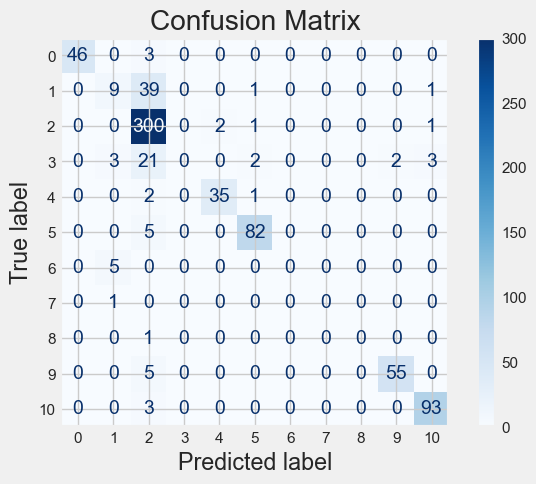

In [177]:
# Required package 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming Y_test and svc.predictions are already defined and available

# Define class names
class_names = [str(i) for i in range(11)]  # Convert to strings if necessary for display

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, svc.predictions)

# Set precision for numpy output
np.set_printoptions(precision=2)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))

# Use ConfusionMatrixDisplay for better readability and formatting
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  # You can change cmap for color options (e.g., 'Blues')

# Set plot title and show the plot
plt.title('Confusion Matrix')
plt.show()

#### Learning curve


A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the scikit-learn documentation code again

In [179]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [180]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 90.44 % 


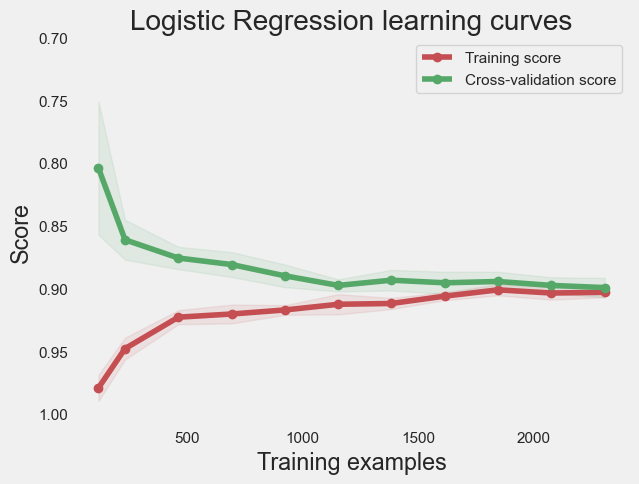

In [183]:
plt.close('all')

g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

In [184]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 80.75 % 


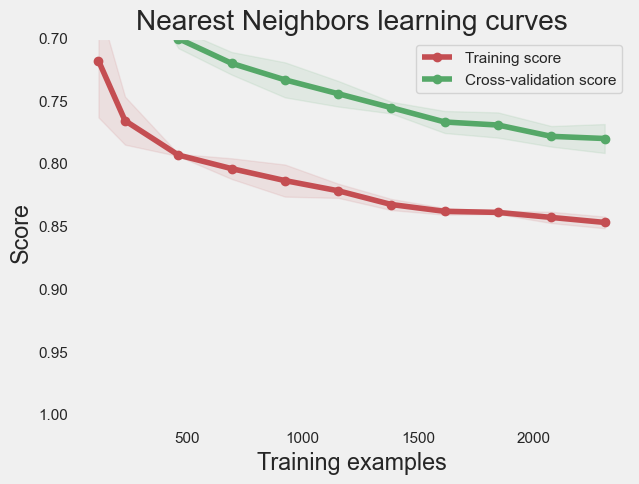

In [185]:
plt.close('all')

g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

In [186]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 81.58 % 


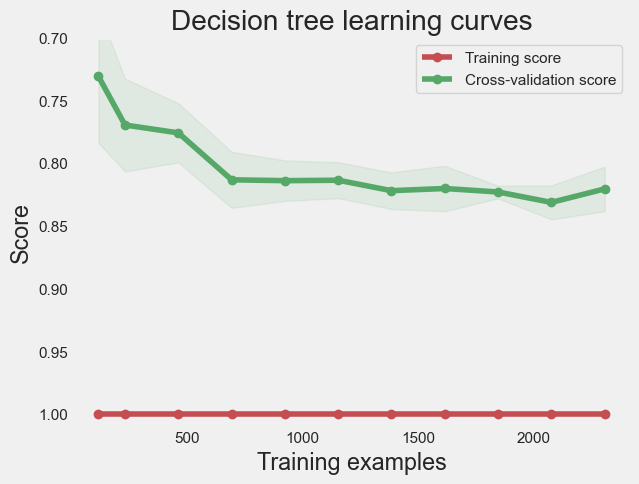

In [187]:
plt.close('all')

g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

In [188]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.44 % 


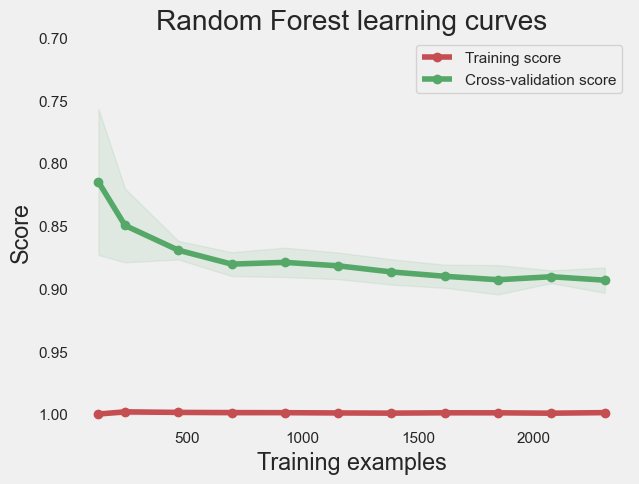

In [189]:
plt.close('all')


g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

In [191]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 55.26 % 


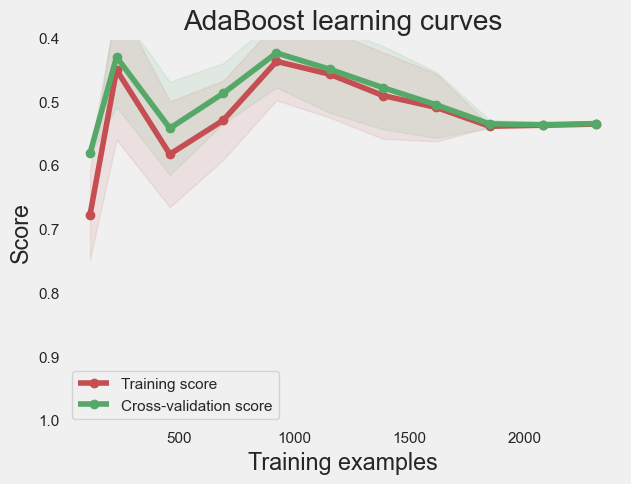

In [192]:
plt.close('all')

g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

In [193]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 89.61 % 


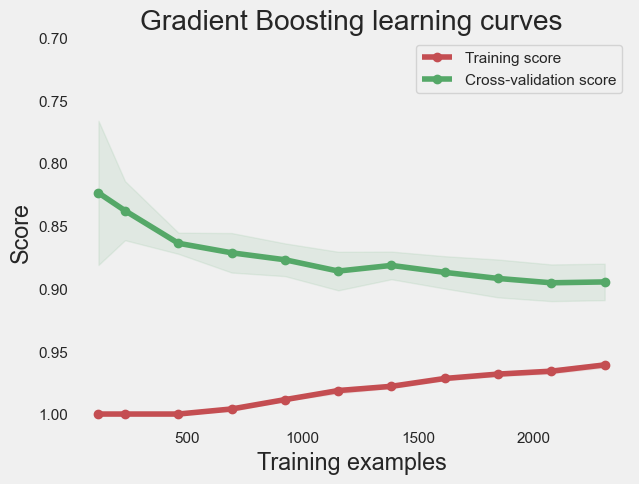

In [194]:
plt.close('all')

g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

#### Holding a vote 

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, we use the VotingClassifier method of the sklearn package. As a first step, we adjust the parameters of the various classifiers using the best parameters previously found:

In [195]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [196]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')  

In [197]:
votingC = votingC.fit(X_train, Y_train)

In [198]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 90.17 % 
